In [1]:
import os
import torch
import pyspch.sp as Sps
import pyspch.display as Spd
import pyspch.core as Spch
import pyspch.nn as Spnn

D:\ProgramFiles\miniconda3\envs\pyspch_edit\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
## Paths
timit_path = 'W:/timit/CDdata/timit/' # to extract corpus, features, labels
remote_path = 'https://homes.esat.kuleuven.be/~spchlab/pyspch/' # to read corpus, features, labels
local_path = 'D:/gitlab/psi/compi1234/nn/' # to write corpus, features, labels
os.chdir(local_path)

In [14]:
## Setup
train_corpus_file = remote_path + 'timit/timit_train.corpus'
val_corpus_file =  None
test_corpus_file =  remote_path + 'timit/timit_test.corpus'
meta_file =  remote_path + 'timit/timit.meta'
feature_path =  remote_path + 'timit/mfcc13/'
feature_args =  {
    'spg': None,
    'Deltas': 'delta_delta2',
    'Norm': 'mean',
    'sample_rate': 16000,
    'f_shift': 0.01,
    'f_length': 0.03,
    'preemp': 0.97,
    'window': 'hamm',
    'mode': 'dB',
    'n_mels': 24,
    'n_cep': 13
    }
label_path =  remote_path + 'timit/segmentation/'
label_args = {
    'extension': '.phn', 
    'pad': 'h#',
    }
sampler_args = {
    'N': 5,
    'stride': 2,
    'mode': 'flatten1d',
    }
lab2lab = Spch.get_timit_mapping(set1="timit61", set2="timit41")
lab2idx = {k: i for i, k in enumerate(Spch.TIMIT41)}
model_args = {
    'type': 'ffdnn',
    'in_dim': 13 * 3 * 11,
    'out_dim': 41,
    'hidden_layer_dims': [1024, 768, 512] 
    }
training_args = {
    'n_epoch': 150,
    'patience': 15,
    'lrn_rate': 0.01,
    'weight_decay': 0,
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'val_frac': 0.1,
    'val_seed': 1234,
}

## TIMIT corpus

In [4]:
## Read corpus and meta data (from url)
train_corpus = Spch.read_data_file(train_corpus_file)
test_corpus = Spch.read_data_file(test_corpus_file)
meta = Spch.read_dataframe(meta_file)

In [34]:
## SpchData
train_data = Spnn.SpchData(train_corpus)
test_data = Spnn.SpchData(test_corpus)

## Read features from disk (from url) ~ 25 min
data_path = remote_path + 'timit/mfcc13/'
train_data.read_features(data_path)
test_data.read_features(data_path)

## Feature extraction arguments for read features
feature_args_file = data_path + 'feature_args.json'
read_feature_args = Spch.read_json_file(feature_args_file)

In [7]:
## Additional feature extraction arguments (for further processing ~ modification)
modify_feature_args = Spch.dct_diff(read_feature_args, feature_args)

## Modify features
train_data.features = [Sps.feature_extraction(spg=feature, **modify_feature_args) for feature in train_data.features]
test_data.features = [Sps.feature_extraction(spg=feature, **modify_feature_args) for feature in test_data.features]

In [37]:
## Labels ~ 25 min
shift = feature_args['f_shift'] * feature_args['sample_rate']
train_data.extract_alligned_labels(label_path, shift, label_args['pad'], label_args['extension'])
test_data.extract_alligned_labels(label_path, shift, label_args['pad'], label_args['extension'])

In [40]:
## SpchData alternative #2
import pandas as pd
if False:
    train_df = train_data.to_dataframe()
    test_df = test_data.to_dataframe()
    train_df.to_pickle('D:/gitlab/psi/compi1234/nn/data/mfcc13/train.pkl')
    test_df.to_pickle('D:/gitlab/psi/compi1234/nn/data/mfcc13/test.pkl')

if True:
    train_df = pd.read_pickle('D:/gitlab/psi/compi1234/nn/data/mfcc13/train.pkl')
    test_df = pd.read_pickle('D:/gitlab/psi/compi1234/nn/data/mfcc13/test.pkl')
    train_data = Spnn.DataFrame_to_SpchData(train_df)
    test_data = Spnn.DataFrame_to_SpchData(test_df) 
    train_data.features = [Sps.feature_extraction(spg=feature, **modify_feature_args) for feature in train_data.features]
    test_data.features = [Sps.feature_extraction(spg=feature, **modify_feature_args) for feature in test_data.features] 

NameError: name 'modify_feature_args' is not defined

['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year']


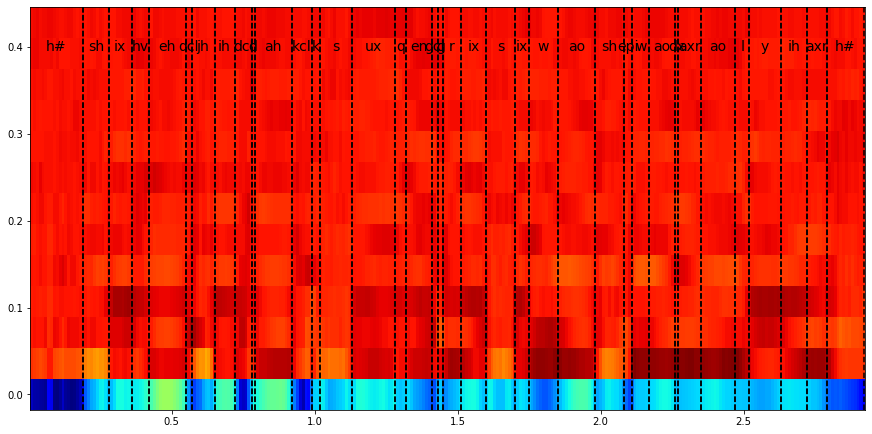

In [39]:
## Plot example
text = Spch.read_data_file(remote_path + "timit/segmentation/" + train_data.corpus[0] + ".wrd", maxcols=3, as_cols=True)
print(text[-1])
spgdata = train_data.features[0]
spgseg = Spch.lbls2seg(train_data.labels[0])
Spd.PlotSpg(spgdata=spgdata, segspg=spgseg)

In [16]:
## SpchDataset 
train_ds = Spnn.SpchDataset(train_data.corpus, train_data.features, train_data.labels)
test_ds = Spnn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)

## Target 
train_ds.map_target(lab2lab)
train_ds.encode_target(lab2idx)
train_ds.to_tensor()
test_ds.map_target(lab2lab)
test_ds.encode_target(lab2idx)
test_ds.to_tensor()

## Sampler with splicing
train_ds.set_sampler(train_data.get_length('features'), sampler_args)
test_ds.set_sampler(test_data.get_length('features'), sampler_args)

In [17]:
## FFDNN model 
model = Spnn.FFDNN(model_args['in_dim'], model_args['out_dim'], model_args['hidden_layer_dims'])

## Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model.to(device)
train_ds.to_device(device)
test_ds.to_device(device)

## Criterion + Optimizer + learning rate-scheduler
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=training_args['lrn_rate'], 
                             weight_decay=training_args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
    mode='min', factor=0.1, patience=10, threshold=0.0001, 
    threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [18]:
## Validation set (split fraction from train set)
valid_ds, train_ds = train_ds.split(training_args['val_frac'], training_args['val_seed'])

## Dataloader (validation set)
if valid_ds is not None:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])
else:
    valid_dl = None
    
## Dataloader (train set)
train_dl = torch.utils.data.DataLoader(train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

In [19]:
## Train model ~ 5min per epoch
every = 1
current_epoch = 0
tr_loss, val_loss, epoch = Spnn.train(model, train_dl, criterion, optimizer, 
    clip=None, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=every)

Epoch 0 -- av. train loss per mini-batch 1.91
	 -- av. validation loss per mini-batch 1.91
Epoch 1 -- av. train loss per mini-batch 1.81
	 -- av. validation loss per mini-batch 1.80


KeyboardInterrupt: 

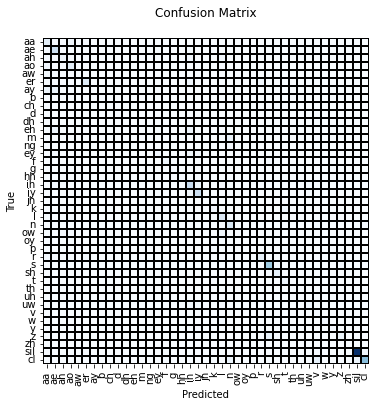

PER: 0.4951128618073555


In [13]:
## Evaluate loss and confusion matrix 
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)
loss = Spnn.evaluate(model, test_dl, criterion)
cm = Spnn.evaluate_cm(model, test_dl)

# plot confusion matrix
labels = list(lab2idx.keys())
(f, ax) = Spch.plot_confusion_matrix(cm, labels, title='Confusion Matrix\n', figsize=(6,6), annot=False)

# Phone error rate
per = Spnn.cm2per(cm)
print(f'PER: {per[0]}')

In [12]:
## Write model checkpoint
model_file = local_path + "models/ffdnn_small_dummy.pt"
torch.save({
    'train_corpus_file': train_corpus_file,
    'val_corpus_file': val_corpus_file,
    'test_corpus_file': test_corpus_file,
    'meta_file': meta_file,
    'feature_path': feature_path,
    'feature_args': feature_args,
    'modify_feature_args': modify_feature_args,
    'label_path': label_path,
    'label_args': label_args, 
    'sampler_args': sampler_args,
    'model_args': model_args,
    'training_args': training_args,
    'criterion': criterion,
    'optimizer': optimizer,
    'clip': None,
    'scheduler': scheduler,
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lab2lab': lab2lab,
    'lab2idx': lab2idx,   
}, model_file)

In [13]:
## Read model checkpoint
model_file = local_path + "models/ffdnn_small_dummy.pt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
chpt = torch.load(model_file, map_location=device)

In [14]:
## Read corpus and meta data (from checkpoint)
meta = Spch.read_dataframe(chpt['meta'])

## SpchData
train = Spch.read_data_file(chpt['train_corpus'])
train_data = Spnn.SpchData(train)
train_data.read_features(chpt['feature_path'])
feature_args = chpt['feature_args']
modify_feature_args = chpt['modify_feature_args']
train_data.features = [Sps.feature_extraction(spg=feature, **modify_feature_args) for feature in train_data.features]
feature_args.update(modify_feature_args)
shift = feature_args['f_shift'] * feature_args['sample_rate']
train_data.extract_alligned_labels(chpt['label_path'], shift, chpt['label_pad'], chpt['label_extension'])

## SpchDataset
train_ds = Spnn.SpchDataset(train_data.corpus, train_data.features, train_data.labels)
train_ds.map_target(chpt['lab2lab'])
train_ds.encode_target(chpt['lab2idx'])
train_ds.to_tensor()
lengths = train_data.get_length('features')
train_ds.set_sampler(lengths, chpt['sampler_args'])
train_ds.to_device(device)

## Model
model_args = chpt['model_args']
model = Spnn.FFDNN(model_args['in_dim'], model_args['out_dim'], model_args['hidden_layer_dims'])
model.to(device)

## Training
current_epoch = chpt['epoch']
training_args = chpt['training_args']
criterion = chpt['criterion']
optimizer = chpt['optimizer']
clip = chpt['clip']
scheduler = chpt['scheduler']

## Loading model parameters
model.load_state_dict(chpt["model_state_dict"])
optimizer.load_state_dict(chpt["optimizer_state_dict"])

## Validation set
if training_args['val_frac'] is not None:
    n_ex = len(data_ds)
    n_valid = int(n_ex * training_args['val_frac'])
    n_train = n_ex - n_valid
    if training_args['val_seed'] is not None: torch.manual_seed(training_args['val_seed'])
    valid_ds, train_ds = torch.utils.data.random_split(data_ds, [n_valid, n_train])
else:
    train_ds = data_ds
    
## Dataloader 
train_dl = torch.utils.data.DataLoader(train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

if training_args['val_frac'] is not None:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])
else:
    valid_dl = None

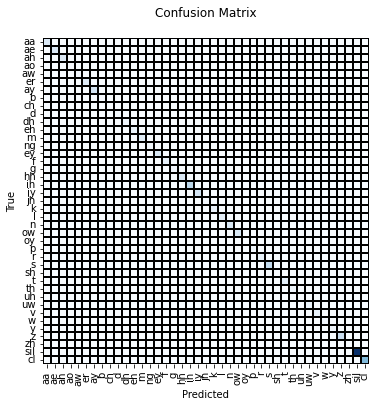

PER: 0.0


In [15]:
## Evaluate loss and confusion matrix (on train set)
test_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=0)
loss = Spnn.evaluate(model, test_dl, criterion)
cm = Spnn.evaluate_cm(model, test_dl)

# plot confusion matrix
labels = list(lab2idx.keys())
(f, ax) = Spch.plot_confusion_matrix(cm, labels, title='Confusion Matrix\n', figsize=(6,6), annot=False)

# Phone error rate
per = Spnn.cm2per(cm)
print(f'PER: {per[0]}')

In [16]:
## Train model (continued)
print(f'Current epoch is {current_epoch}')
tr_loss, val_loss, epoch = Spnn.train(model, train_dl, criterion, optimizer, 
    clip=clip, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=every)

Current epoch is 49
Epoch 50 -- av. train loss per mini-batch 0.03
Epoch 55 -- av. train loss per mini-batch 0.03
Epoch 60 -- av. train loss per mini-batch 0.03
Epoch 65 -- av. train loss per mini-batch 0.03
Epoch 70 -- av. train loss per mini-batch 0.03
Epoch 75 -- av. train loss per mini-batch 0.03
Epoch 80 -- av. train loss per mini-batch 0.03
Epoch 85 -- av. train loss per mini-batch 0.03
Epoch 90 -- av. train loss per mini-batch 0.03
Epoch 95 -- av. train loss per mini-batch 0.03
